In [1]:
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression  # For log_reg_model
from sklearn.ensemble import RandomForestClassifier  # For rf_model
from sklearn.neighbors import KNeighborsClassifier  # For knn_model
from sklearn.tree import DecisionTreeClassifier  # For dt_model
from sklearn.ensemble import GradientBoostingClassifier  # For gb_model
from sklearn.ensemble import AdaBoostClassifier  # For ab_model
from sklearn.naive_bayes import MultinomialNB  # For nb_model
from xgboost import XGBClassifier  # For xgb_model
from lightgbm import LGBMClassifier  # For lgbm_model
from catboost import CatBoostClassifier  # For catboost_model
from imblearn.over_sampling import SMOTE  # For SMOTE oversampling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
df = pd.read_csv('My_Vader_Data.csv')

In [4]:
df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,...,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Complaint ID,consumer_narrative,Sentiment_Score,Sentiment_Label,Anger_Level
0,0,0,0,06/28/21,Checking or savings account,Checking account,Managing an account,Problem accessing account,I had to report my card stolen and report frau...,NaN,...,Consent provided,Web,07/22/21,Closed with explanation,Yes,4499000,report card stolen report fraudulent activity ...,-0.5267,Negative,Angry
1,1,1,1,06/28/21,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,Dear wise.com is a wire transfer company. \nI ...,NaN,...,Consent provided,Web,07/14/21,Closed with explanation,Yes,4499207,dear wisecom wire transfer company tryed send ...,0.8289,Positive,Not Angry
2,2,2,2,06/27/21,Mortgage,FHA mortgage,Applying for a mortgage or refinancing an exis...,NaN,"I was reluctant to think this, but it felt as ...",NaN,...,Consent provided,Web,06/27/21,Closed with explanation,Yes,4494886,wa reluctant think felt though discriminated t...,0.9505,Positive,Not Angry
3,3,3,3,07/01/21,Debt collection,Credit card debt,Written notification about debt,Didn't receive enough information to verify debt,I am not liable for this debt with XXXX and I ...,Company believes the complaint provided an opp...,...,Consent provided,Web,07/01/21,Closed with explanation,Yes,4507730,liable debt contract mountain run solution plu...,0.2960,Positive,Not Angry
4,4,4,4,02/13/21,"Payday loan, title loan, or personal loan",Payday loan,Can't contact lender or servicer,NaN,A form was faxed to a doctor office in the sam...,NaN,...,Consent provided,Web,03/03/21,Closed with explanation,Yes,4138020,form wa faxed doctor office building work stat...,-0.8456,Negative,Furious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230339,230339,230339,230339,11/01/21,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,I recently check my credit report due to me ow...,NaN,...,Consent provided,Web,11/01/21,Closed with explanation,Yes,4864559,recently check credit report due owning busine...,-0.9965,Negative,Seething
230340,230340,230340,230340,10/05/21,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,XX/XX/2021 RE : Foreclosure Sale TS No : XXXX ...,NaN,...,Consent provided,Web,10/05/21,Closed with explanation,Yes,4782618,foreclosure sale quality loan service corporat...,0.9932,Positive,Not Angry
230341,230341,230341,230341,08/06/21,Mortgage,Conventional home mortgage,Applying for a mortgage or refinancing an exis...,NaN,This is an amendment to compliant XXXX-XXXX. I...,NaN,...,Consent provided,Web,08/06/21,Closed with explanation,Yes,4608059,amendment compliant amending complaint add ema...,-0.8273,Negative,Furious
230342,230342,230342,230342,03/25/21,Mortgage,Conventional home mortgage,Closing on a mortgage,NaN,I've outlined my complaint to the bank below. ...,NaN,...,Consent provided,Web,03/25/21,Closed with explanation,Yes,4247481,ive outlined complaint bank despite flurry act...,0.9983,Positive,Not Angry


In [5]:
columns_to_drop = ['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0']
df = df.drop(columns=columns_to_drop, axis=1)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from gensim.models import Word2Vec

def preprocess_data(df, n_gram_range=(1, 3), max_features=20, test_size=0.2, validation_size=0.2, random_state=42):
    # Ensure 'consumer_narrative' column is of string type
    df['consumer_narrative'] = df['consumer_narrative'].astype(str)

    # Label encode the Anger_Level column in the dataset
    le = LabelEncoder()
    df['Anger_Level_encoded'] = le.fit_transform(df['Anger_Level'])

    # Split data into features and target
    X = df['consumer_narrative']
    y = df['Anger_Level_encoded']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Further split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state)

    # TF-IDF vectorization with n-grams on training, validation, and testing data
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=n_gram_range)
    start_tfidf_time = time.time()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_val_tfidf = vectorizer.transform(X_val)
    X_test_tfidf = vectorizer.transform(X_test)
    end_tfidf_time = time.time()
    tfidf_vectorization_time = end_tfidf_time - start_tfidf_time

    # Convert tokenized sentences to lists of words for Word2Vec
    sentences_train = df.loc[X_train.index, 'consumer_narrative']
    sentences_val = df.loc[X_val.index, 'consumer_narrative']
    sentences_test = df.loc[X_test.index, 'consumer_narrative']

    # Train a Word2Vec model on the training data
    word2vec_model = Word2Vec(sentences_train, vector_size=100, window=5, min_count=1, workers=4)

    # Function to get the Word2Vec embedding for a document
    def get_word2vec_embedding(tokens):
        embedding = np.mean([word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv], axis=0)
        if np.isnan(embedding).any():  # Handle cases where none of the words are in the Word2Vec model
            embedding = np.zeros(100)
        return embedding

    # Get Word2Vec embeddings for training, validation, and testing data
    X_train_word2vec = np.array([get_word2vec_embedding(tokens) for tokens in sentences_train])
    X_val_word2vec = np.array([get_word2vec_embedding(tokens) for tokens in sentences_val])
    X_test_word2vec = np.array([get_word2vec_embedding(tokens) for tokens in sentences_test])

    # Combine TF-IDF features and Word2Vec embeddings for training, validation, and testing data
    X_train_combined = np.hstack((X_train_tfidf.toarray(), X_train_word2vec))
    X_val_combined = np.hstack((X_val_tfidf.toarray(), X_val_word2vec))
    X_test_combined = np.hstack((X_test_tfidf.toarray(), X_test_word2vec))

    return X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, tfidf_vectorization_time, le



In [7]:
X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, tfidf_vectorization_time, le = preprocess_data(df)

In [8]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix, mean_squared_error, r2_score, roc_curve, auc

In [10]:
def train_and_evaluate_model(model, X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, tfidf_vectorization_time, le, random_state=42, patience=3):
    # Define Stratified KFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # Cross-validation loop with early stopping (using custom implementation)
    best_score = 0
    patience_counter = 0

    start_training_time = time.time()  # Start timing the training process

    # Convert y_train to a NumPy array
    y_train_array = np.array(y_train)

    for train_index, val_index in skf.split(X_train_combined, y_train_array):
        X_train_fold, X_val_fold = X_train_combined[train_index], X_train_combined[val_index]
        y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)
        f1 = f1_score(y_val_fold, y_val_pred, average='weighted')

        if f1 > best_score:
            best_score = f1
            best_model = model
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

    end_training_time = time.time()  # End timing the training process
    training_time = end_training_time - start_training_time

    print("Best Cross-Validation F1-score:", best_score)

    # Train the model on the entire training data
    best_model.fit(X_train_combined, y_train)

    # Predict encoded anger levels for test data
    start_prediction_time = time.time()
    y_pred = best_model.predict(X_test_combined)
    end_prediction_time = time.time()
    prediction_time = end_prediction_time - start_prediction_time

    # Evaluation
    print("F1-score (weighted):", f1_score(y_test, y_pred, average='weighted'))
    print(classification_report(y_test, y_pred))

    # Confusion matrix with heatmap
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Anger Level (Encoded)')
    plt.ylabel('Actual Anger Level (Encoded)')
    plt.show()

    # ROC Curve and AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_combined)
    else:  # For models without predict_proba, use decision_function
        y_prob = model.decision_function(X_test_combined)
        y_prob = np.exp(y_prob) / np.sum(np.exp(y_prob), axis=1, keepdims=True)  # Softmax to convert to probabilities

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(len(le.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i, color in zip(range(len(le.classes_)), ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print training and prediction times
    print(f"TF-IDF Vectorization Time: {tfidf_vectorization_time:.4f} seconds")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Prediction Time: {prediction_time:.4f} seconds")

    # Compute and print MSE and R² score for training and validation sets
    y_train_pred = best_model.predict(X_train_combined)
    y_val_pred = best_model.predict(X_val_combined)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"Training MSE: {train_mse:.4f}")
    print(f"Validation MSE: {val_mse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Validation R²: {val_r2:.4f}")



In [11]:
# Define models
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
rf_model = RandomForestClassifier(random_state=42)
knn_model = KNeighborsClassifier()
dt_model = DecisionTreeClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
lgbm_model = LGBMClassifier(random_state=42)
catboost_model = CatBoostClassifier(random_state=42, verbose=0)


Evaluating LogisticRegression
Best Cross-Validation F1-score: 0.5145327599095362
F1-score (weighted): 0.5147326950773076
              precision    recall  f1-score   support

           0       0.17      0.00      0.01      3779
           1       0.37      0.06      0.11      5440
           2       0.36      0.11      0.17      5380
           3       0.64      0.96      0.77     27579
           4       0.37      0.18      0.24      3891

    accuracy                           0.61     46069
   macro avg       0.38      0.26      0.26     46069
weighted avg       0.51      0.61      0.51     46069



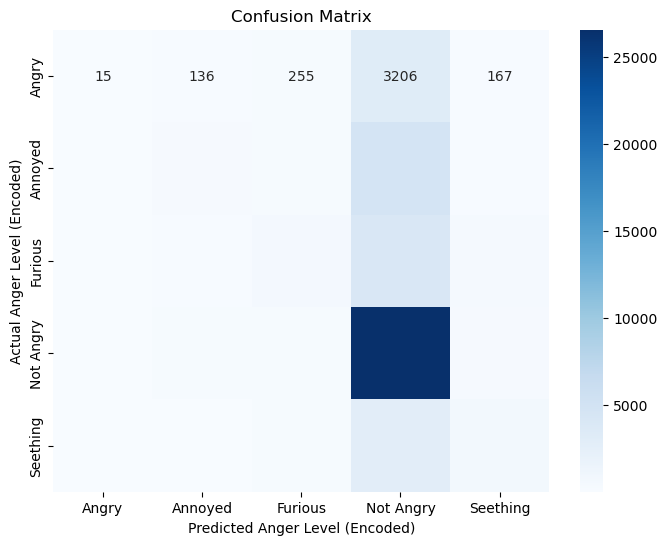

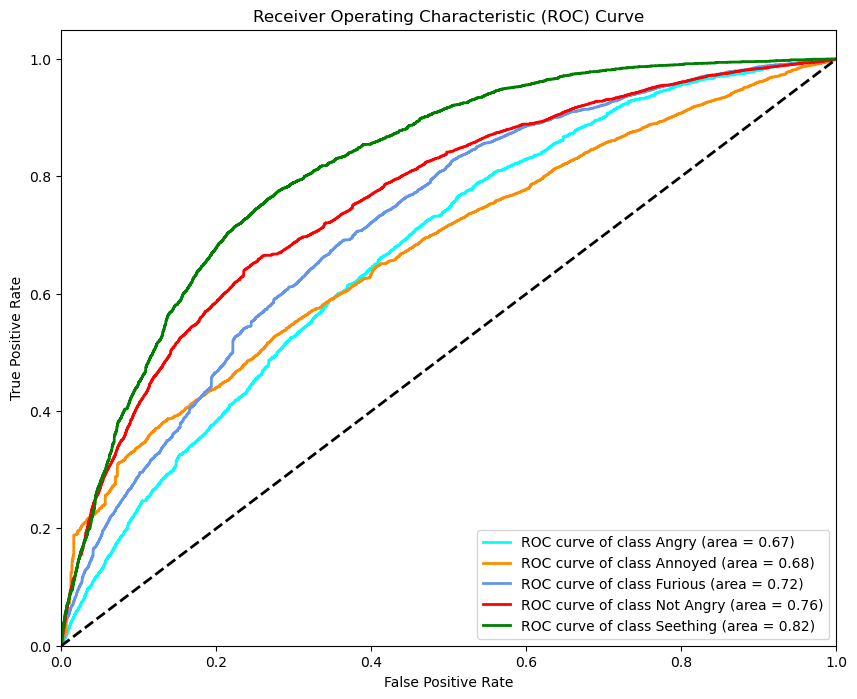

TF-IDF Vectorization Time: 84.8091 seconds
Training Time: 77.5595 seconds
Prediction Time: 0.0292 seconds
Training MSE: 1.4340
Validation MSE: 1.4120
Training R²: -0.2514
Validation R²: -0.2501


Evaluating RandomForestClassifier
Best Cross-Validation F1-score: 0.6916426464607306
F1-score (weighted): 0.7001200882736721
              precision    recall  f1-score   support

           0       0.91      0.27      0.42      3779
           1       0.97      0.42      0.59      5440
           2       0.82      0.36      0.50      5380
           3       0.71      0.99      0.83     27579
           4       0.82      0.35      0.49      3891

    accuracy                           0.74     46069
   macro avg       0.84      0.48      0.57     46069
weighted avg       0.78      0.74      0.70     46069



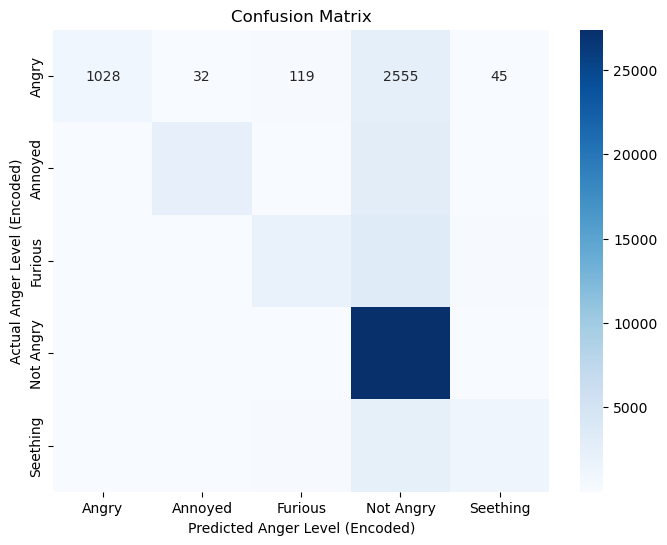

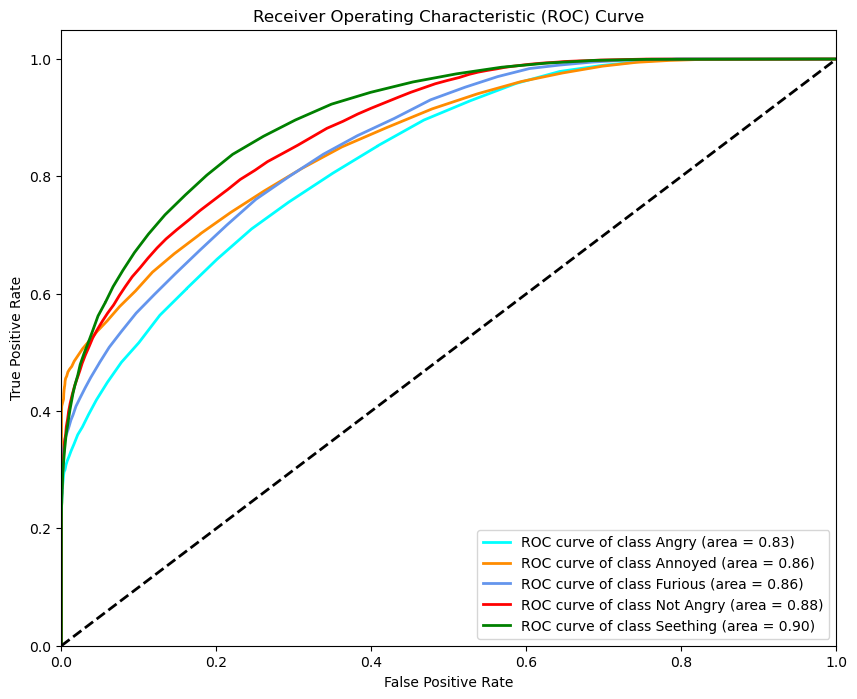

TF-IDF Vectorization Time: 84.8091 seconds
Training Time: 1205.3544 seconds
Prediction Time: 1.4130 seconds
Training MSE: 0.0066
Validation MSE: 0.9408
Training R²: 0.9943
Validation R²: 0.1671


Evaluating KNeighborsClassifier
Best Cross-Validation F1-score: 0.638372534115652
F1-score (weighted): 0.6446813024215047
              precision    recall  f1-score   support

           0       0.35      0.29      0.32      3779
           1       0.54      0.43      0.48      5440
           2       0.44      0.38      0.41      5380
           3       0.75      0.85      0.80     27579
           4       0.51      0.35      0.42      3891

    accuracy                           0.66     46069
   macro avg       0.52      0.46      0.48     46069
weighted avg       0.64      0.66      0.64     46069



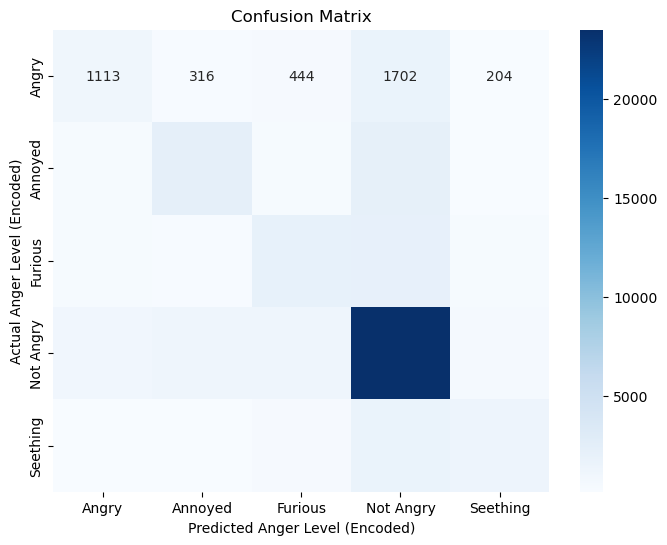

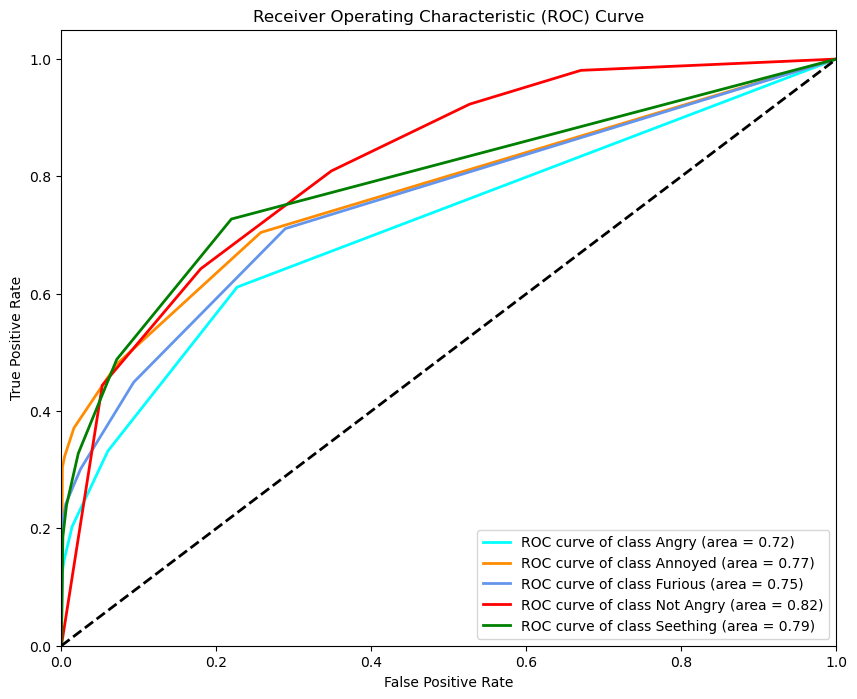

TF-IDF Vectorization Time: 84.8091 seconds
Training Time: 75.9683 seconds
Prediction Time: 30.7778 seconds
Training MSE: 0.9534
Validation MSE: 1.3460
Training R²: 0.1680
Validation R²: -0.1916


Evaluating DecisionTreeClassifier
Best Cross-Validation F1-score: 0.6292437045156917
F1-score (weighted): 0.6365993539720971
              precision    recall  f1-score   support

           0       0.35      0.37      0.36      3779
           1       0.48      0.50      0.49      5440
           2       0.43      0.44      0.44      5380
           3       0.78      0.76      0.77     27579
           4       0.41      0.42      0.41      3891

    accuracy                           0.63     46069
   macro avg       0.49      0.50      0.50     46069
weighted avg       0.64      0.63      0.64     46069



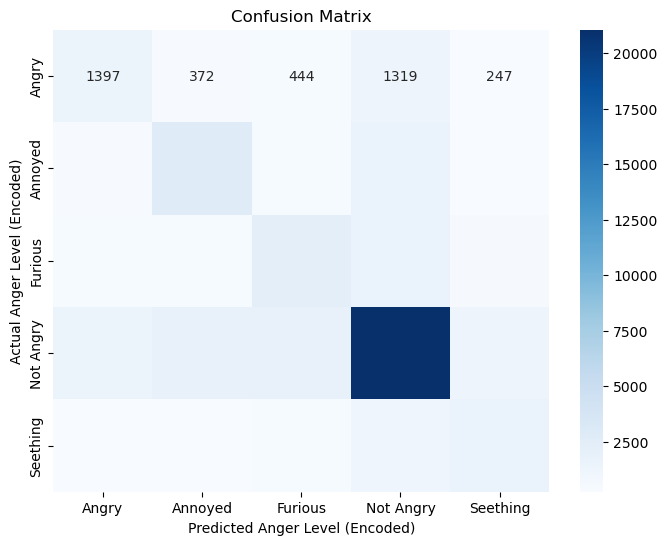

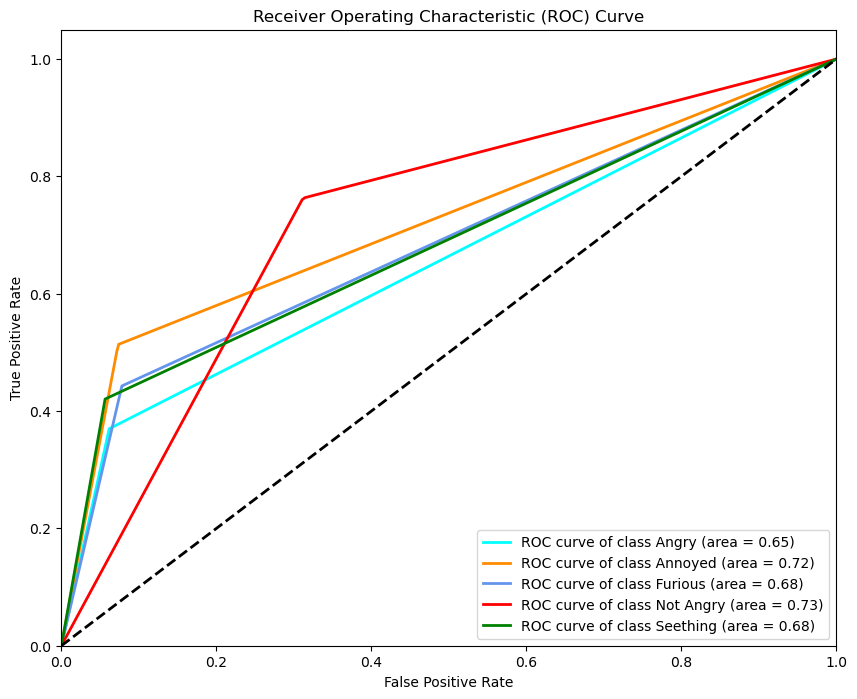

TF-IDF Vectorization Time: 84.8091 seconds
Training Time: 165.6307 seconds
Prediction Time: 0.0161 seconds
Training MSE: 0.0066
Validation MSE: 1.4490
Training R²: 0.9943
Validation R²: -0.2828


Evaluating XGBClassifier
Best Cross-Validation F1-score: 0.6714885784313521
F1-score (weighted): 0.6713861552561329
              precision    recall  f1-score   support

           0       0.69      0.20      0.31      3779
           1       0.88      0.37      0.52      5440
           2       0.64      0.33      0.44      5380
           3       0.71      0.97      0.82     27579
           4       0.62      0.39      0.48      3891

    accuracy                           0.71     46069
   macro avg       0.71      0.45      0.51     46069
weighted avg       0.72      0.71      0.67     46069



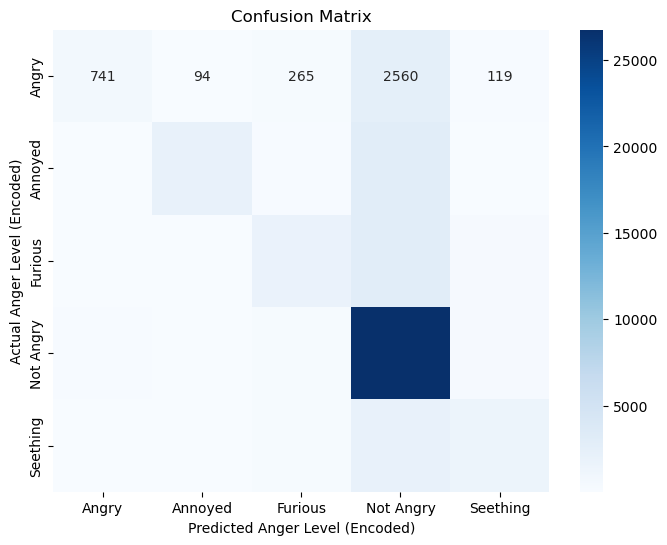

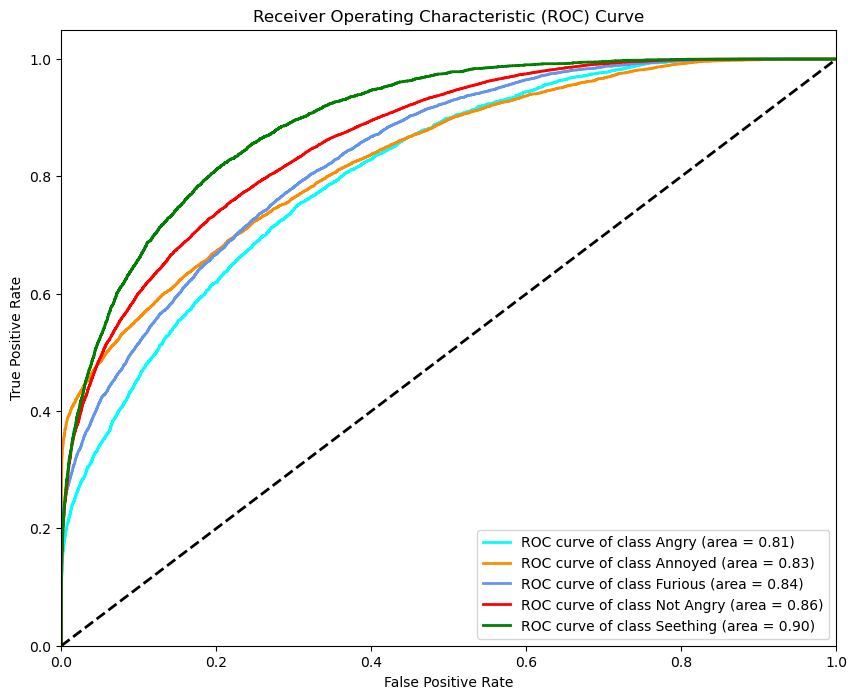

TF-IDF Vectorization Time: 84.8091 seconds
Training Time: 137.1293 seconds
Prediction Time: 0.1985 seconds
Training MSE: 0.8691
Validation MSE: 1.0739
Training R²: 0.2416
Validation R²: 0.0492


Evaluating LGBMClassifier
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30596
[LightGBM] [Info] Number of data points in the train set: 117936, number of used features: 120
[LightGBM] [Info] Start training from score -2.499461
[LightGBM] [Info] Start training from score -2.140486
[LightGBM] [Info] Start training from score -2.142579
[LightGBM] [Info] Start training from score -0.512758
[LightGBM] [Info] Start training from score -2.475992
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30597
[LightGBM] [Info] Nu

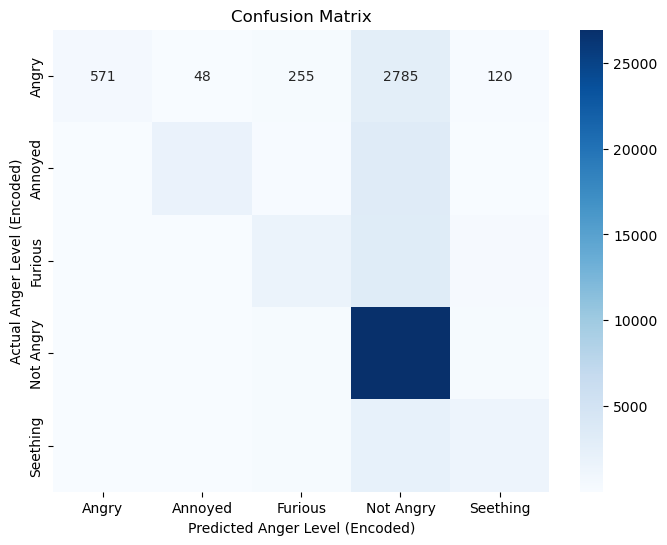

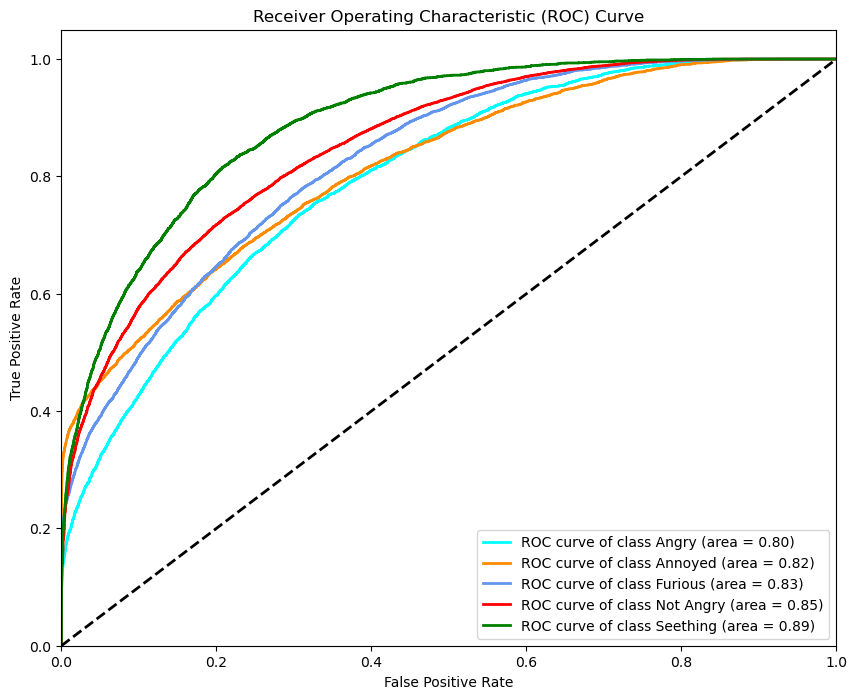

TF-IDF Vectorization Time: 84.8091 seconds
Training Time: 81.7313 seconds
Prediction Time: 0.6902 seconds
Training MSE: 1.0538
Validation MSE: 1.1153
Training R²: 0.0804
Validation R²: 0.0126


Evaluating CatBoostClassifier
Best Cross-Validation F1-score: 0.6553339515889247
F1-score (weighted): 0.653899591776911
              precision    recall  f1-score   support

           0       0.70      0.15      0.24      3779
           1       0.86      0.32      0.47      5440
           2       0.62      0.32      0.42      5380
           3       0.71      0.97      0.82     27579
           4       0.60      0.39      0.47      3891

    accuracy                           0.70     46069
   macro avg       0.70      0.43      0.48     46069
weighted avg       0.70      0.70      0.65     46069



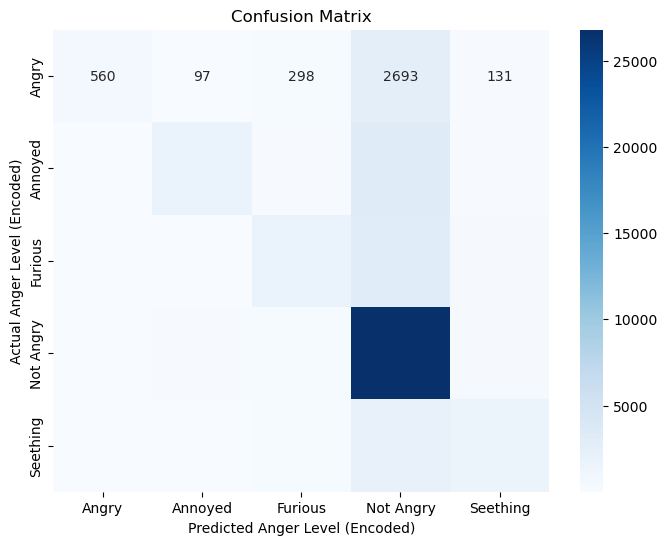

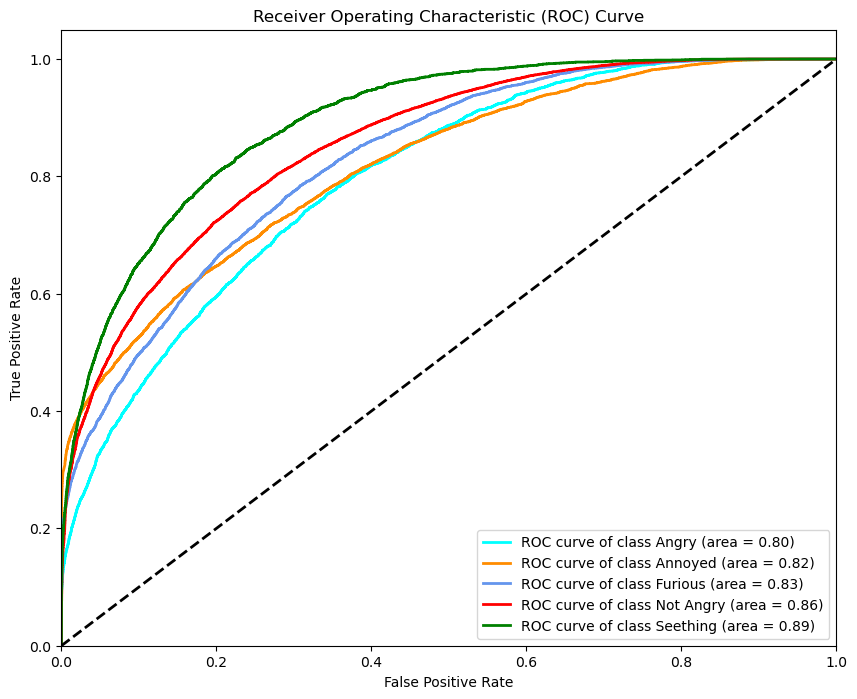

TF-IDF Vectorization Time: 84.8091 seconds
Training Time: 1320.0103 seconds
Prediction Time: 2.3951 seconds
Training MSE: 1.0358
Validation MSE: 1.1163
Training R²: 0.0961
Validation R²: 0.0117




In [12]:
# Train and evaluate each model
models = [log_reg_model, rf_model, knn_model, dt_model, xgb_model, lgbm_model, catboost_model]

for model in models:
    print(f"Evaluating {model.__class__.__name__}")
    train_and_evaluate_model(model, X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, tfidf_vectorization_time, le)
    print("\n" + "="*80 + "\n")

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, GRU, Embedding, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec
import tensorflow as tf

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(100, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape, num_classes):
    model = Sequential([
        GRU(100, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(model, X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, tfidf_vectorization_time, le, random_state=42, patience=3):
    # Convert labels to categorical
    y_train_cat = to_categorical(y_train)
    y_val_cat = to_categorical(y_val)
    y_test_cat = to_categorical(y_test)

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Train the model
    start_training_time = time.time()
    history = model.fit(X_train_combined, y_train_cat, validation_data=(X_val_combined, y_val_cat), epochs=100, callbacks=[early_stopping], batch_size=32)
    end_training_time = time.time()
    training_time = end_training_time - start_training_time

    # Evaluate the model on the test set
    start_prediction_time = time.time()
    y_pred_prob = model.predict(X_test_combined)
    y_pred = np.argmax(y_pred_prob, axis=1)
    end_prediction_time = time.time()
    prediction_time = end_prediction_time - start_prediction_time

    # Evaluation
    print("F1-score (weighted):", f1_score(y_test, y_pred, average='weighted'))
    print(classification_report(y_test, y_pred))

    # Confusion matrix with heatmap
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Anger Level (Encoded)')
    plt.ylabel('Actual Anger Level (Encoded)')
    plt.show()

    # ROC Curve and AUC
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(len(le.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i, color in zip(range(len(le.classes_)), ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print training and prediction times
    print(f"TF-IDF Vectorization Time: {tfidf_vectorization_time:.4f} seconds")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Prediction Time: {prediction_time:.4f} seconds")

    # Compute and print MSE and R² score for training and validation sets
    y_train_pred_prob = model.predict(X_train_combined)
    y_val_pred_prob = model.predict(X_val_combined)
    y_train_pred = np.argmax(y_train_pred_prob, axis=1)
    y_val_pred = np.argmax(y_val_pred_prob, axis=1)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"Training MSE: {train_mse:.4f}")
    print(f"Validation MSE: {val_mse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Validation R²: {val_r2:.4f}")


C:\Users\pcudo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
C:\Users\pcudo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Evaluating CNN
Epoch 1/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.6113 - loss: 1.1055 - val_accuracy: 0.6454 - val_loss: 1.0118
Epoch 2/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.6467 - loss: 1.0064 - val_accuracy: 0.6477 - val_loss: 0.9956
Epoch 3/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.6540 - loss: 0.9803 - val_accuracy: 0.6574 - val_loss: 0.9751
Epoch 4/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.6586 - loss: 0.9662 - val_accuracy: 0.6609 - val_loss: 0.9648
Epoch 5/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.6620 - loss: 0.9545 - val_accuracy: 0.6606 - val_loss: 0.9615
Epoch 6/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.6622 - loss: 0.9505 - val_accuracy: 0.6628 - val_loss: 0.9612
Epoch 7/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.6665 - loss: 0.9392 - val_accuracy: 0.6672 - val_loss: 0.9438
Epoch 8/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - acc

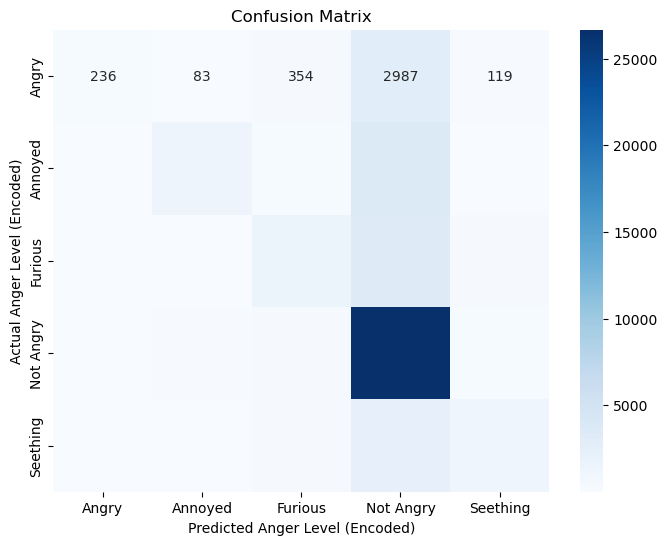

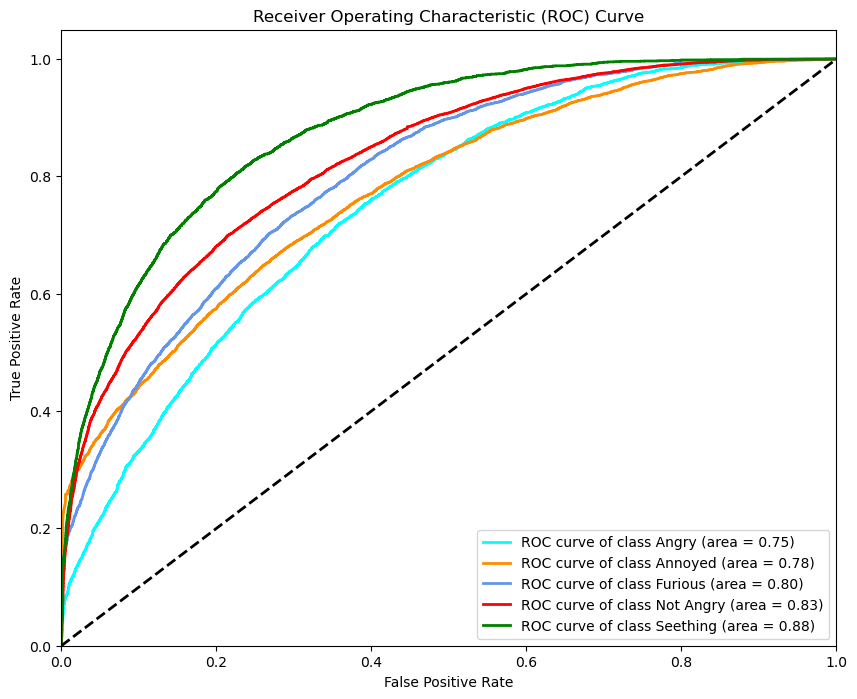

TF-IDF Vectorization Time: 84.8091 seconds
Training Time: 313.5591 seconds
Prediction Time: 4.5657 seconds
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Training MSE: 1.2310
Validation MSE: 1.2226
Training R²: -0.0743
Validation R²: -0.0824


Evaluating LSTM
Epoch 1/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 310s 67ms/step - accuracy: 0.5973 - loss: 1.2352 - val_accuracy: 0.5989 - val_loss: 1.2242
Epoch 2/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 280s 61ms/step - accuracy: 0.5977 - loss: 1.2215 - val_accuracy: 0.5989 - val_loss: 1.1988
Epoch 3/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 275s 60ms/step - accuracy: 0.5998 - loss: 1.1876 - val_accuracy: 0.6056 - val_loss: 1.1653
Epoch 4/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 290s 63ms/step - accuracy: 0.6040 - loss: 1.1801 - val_accuracy: 0.6065 - val_loss: 1.1591
Epoch 5/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 286s 62ms/step - accuracy: 0.6072 - loss: 1.1568 - val_accuracy: 0.6163 - val_loss: 1.1437
Epoch 6/100
4607/4607 ━━━━━━━━

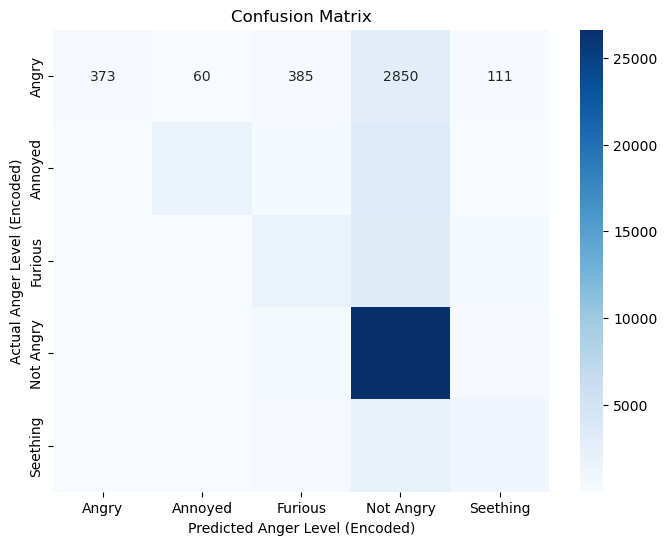

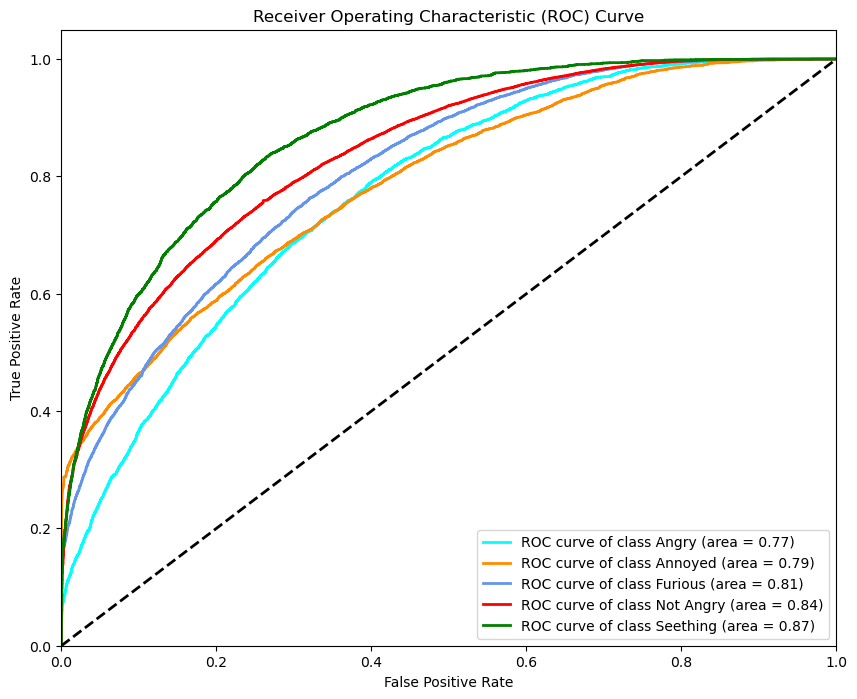

TF-IDF Vectorization Time: 84.8091 seconds
Training Time: 10610.9030 seconds
Prediction Time: 36.9558 seconds
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 105s 23ms/step
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step
Training MSE: 1.1723
Validation MSE: 1.1901
Training R²: -0.0230
Validation R²: -0.0536


Evaluating GRU
Epoch 1/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 347s 75ms/step - accuracy: 0.5990 - loss: 1.2340 - val_accuracy: 0.5989 - val_loss: 1.2088
Epoch 2/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 348s 75ms/step - accuracy: 0.5999 - loss: 1.2034 - val_accuracy: 0.5989 - val_loss: 1.1876
Epoch 3/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 343s 74ms/step - accuracy: 0.6014 - loss: 1.1821 - val_accuracy: 0.6051 - val_loss: 1.1602
Epoch 4/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 344s 75ms/step - accuracy: 0.6130 - loss: 1.1490 - val_accuracy: 0.6247 - val_loss: 1.1078
Epoch 5/100
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 346s 75ms/step - accuracy: 0.6274 - loss: 1.1018 - val_accuracy: 0.6326 - val_loss: 1.0766
Epoch 6/100
4607/4607 ━━

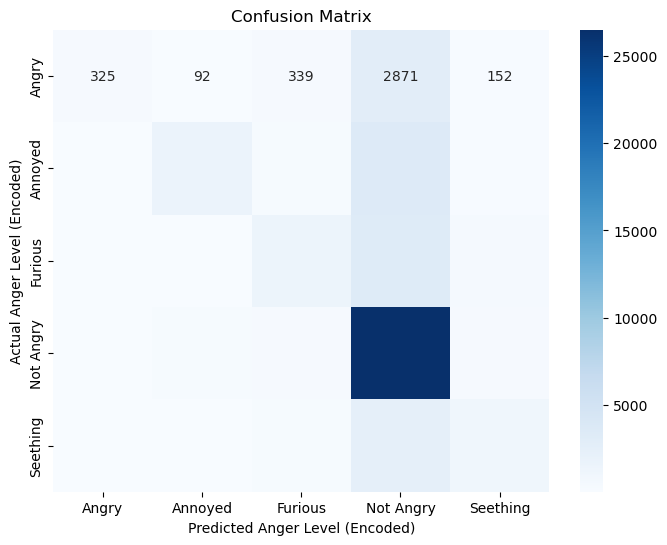

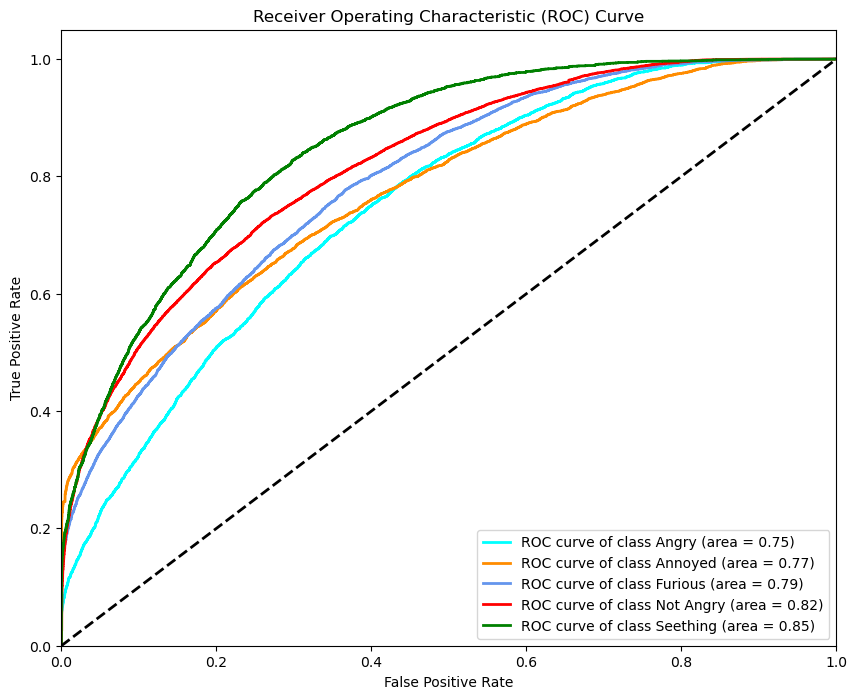

TF-IDF Vectorization Time: 84.8091 seconds
Training Time: 9328.1446 seconds
Prediction Time: 34.2271 seconds
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 102s 22ms/step
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step
Training MSE: 1.2071
Validation MSE: 1.2183
Training R²: -0.0535
Validation R²: -0.0786




In [14]:
# Define the input shape and number of classes
input_shape = (X_train_combined.shape[1], 1)
num_classes = len(le.classes_)

# Reshape the data for CNN, LSTM, and GRU
X_train_combined = X_train_combined.reshape(X_train_combined.shape[0], X_train_combined.shape[1], 1)
X_val_combined = X_val_combined.reshape(X_val_combined.shape[0], X_val_combined.shape[1], 1)
X_test_combined = X_test_combined.reshape(X_test_combined.shape[0], X_test_combined.shape[1], 1)

# Build models
cnn_model = build_cnn_model(input_shape, num_classes)
lstm_model = build_lstm_model(input_shape, num_classes)
gru_model = build_gru_model(input_shape, num_classes)

# Train and evaluate each model
models = [cnn_model, lstm_model, gru_model]
model_names = ["CNN", "LSTM", "GRU"]

for model, name in zip(models, model_names):
    print(f"Evaluating {name}")
    train_and_evaluate_model(model, X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, tfidf_vectorization_time, le)
    print("\n" + "="*80 + "\n")

In [ ]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(100, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape, num_classes):
    model = Sequential([
        GRU(100, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, le):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with early stopping
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

    # Evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, val_acc = model.evaluate(X_val, y_val, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Predictions
    y_pred = model.predict_classes(X_test)

    # Classification report
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Anger Level (Encoded)')
    plt.ylabel('Actual Anger Level (Encoded)')
    plt.show()


In [ ]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(100, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape, num_classes):
    model = Sequential([
        GRU(100, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, le):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with early stopping
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

    # Evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, val_acc = model.evaluate(X_val, y_val, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Predictions
    y_pred = model.predict_classes(X_test)

    # Classification report
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Anger Level (Encoded)')
    plt.ylabel('Actual Anger Level (Encoded)')
    plt.show()


In [ ]:
# Define the input shape and number of classes
input_shape = (X_train_combined.shape[1],)
num_classes = len(np.unique(y_train))

# Reshape the data for LSTM and GRU models
X_train_combined_reshaped = X_train_combined.reshape(X_train_combined.shape[0], X_train_combined.shape[1], 1)
X_val_combined_reshaped = X_val_combined.reshape(X_val_combined.shape[0], X_val_combined.shape[1], 1)
X_test_combined_reshaped = X_test_combined.reshape(X_test_combined.shape[0], X_test_combined.shape[1], 1)

# Build models
cnn_model = build_cnn_model(input_shape, num_classes)
lstm_model = build_lstm_model(input_shape, num_classes)
gru_model = build_gru_model(input_shape, num_classes)

# Define Stratified KFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate each model with cross-validation
models = [cnn_model, lstm_model, gru_model]
model_names = ["CNN", "LSTM", "GRU"]

for model, name in zip(models, model_names):
    print(f"Evaluating {name}")
    for fold_index, (train_index, val_index) in enumerate(skf.split(X_train_combined, y_train)):
        X_train_fold, X_val_fold = X_train_combined[train_index], X_train_combined[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        print(f"Fold {fold_index + 1}")
        train_and_evaluate_model(model, X_train_fold, X_val_fold, X_test_combined_reshaped, y_train_fold, y_val_fold, y_test, le)
        print("\n" + "="*80 + "\n")